# Depth Data Analysis for DynSLAM

In [121]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from matplotlib import rc
# Enable full LaTeX support in plot text. Requires a full-fledged LaTeX installation
# on your system, accessible via PATH.
rc('text', usetex=True)

plt.rcParams["figure.figsize"] = (16, 6)

# TODO(andrei): Remember that box-and-whisker plots can be VERY informative.

In [122]:
%ls ../cmake-build-debug/*.csv

../cmake-build-debug/kitti-odometry-01-offset-30-depth-precomputed-elas-voxelsize-0.0350-results.csv
../cmake-build-debug/kitti-odometry-03-offset-0-depth-precomputed-dispnet-voxelsize-0.0350-results.csv
../cmake-build-debug/kitti-odometry-03-offset-0-depth-precomputed-elas-voxelsize-0.0350-results.csv
../cmake-build-debug/kitti-odometry-04-offset-0-depth-precomputed-dispnet-voxelsize-0.0350-results.csv
../cmake-build-debug/kitti-odometry-05-offset-0-depth-precomputed-dispnet-voxelsize-0.0350-results.csv
../cmake-build-debug/kitti-odometry-05-offset-0-depth-precomputed-elas-voxelsize-0.0350-results.csv
../cmake-build-debug/kitti-odometry-05-offset-2054-depth-precomputed-elas-voxelsize-0.0350-results.csv
../cmake-build-debug/kitti-odometry-06-offset-0-depth-precomputed-dispnet-voxelsize-0.0350-results.csv
../cmake-build-debug/kitti-odometry-06-offset-0-depth-precomputed-elas-voxelsize-0.0350-results.csv
../cmake-build-debug/kitti-odometry-06-offset-0-depth-precomputed-elas-voxelsize-0.1

In [123]:
# CSV_FILE_DISPNET = "../cmake-build-debug/kitti-odometry-06-offset-0-depth-precomputed-dispnet-voxelsize-0.0350-results.csv"
# CSV_FILE_ELAS = "../cmake-build-debug/kitti-odometry-08-offset-3969-results.csv"
# CSV_FILE_ELAS = "../cmake-build-debug/kitti-odometry-06-offset-0-depth-precomputed-elas-voxelsize-0.0350-results.csv"

CSV_FILE_DISPNET="../cmake-build-debug/kitti-odometry-05-offset-0-depth-precomputed-dispnet-voxelsize-0.0350-results.csv"
CSV_FILE_ELAS="../cmake-build-debug/kitti-odometry-05-offset-0-depth-precomputed-elas-voxelsize-0.0350-results.csv"

In [124]:
frame_dn = pd.read_csv(CSV_FILE_DISPNET)
frame_elas = pd.read_csv(CSV_FILE_ELAS)
DELTA_MAX = 10

len(frame_dn), len(frame_elas)

def augment(dframe):
    for name in ['input', 'fusion']:
        for delta in range(1, DELTA_MAX+1):
            total = dframe['{}-total-{}'.format(name, delta)]
            error = dframe['{}-error-{}'.format(name, delta)]
            missing = dframe['{}-missing-{}'.format(name, delta)]
            correct = dframe['{}-correct-{}'.format(name, delta)]

            dframe['{}-error-percent-{}'.format(name, delta)] = error / total
            dframe['{}-missing-percent-{}'.format(name, delta)] = missing / total
            dframe['{}-correct-percent-{}'.format(name, delta)] = correct / total
            
            
augment(frame_dn)
augment(frame_elas)


## Timeseries Comparison Plots

These could show how the error% for different configs changes over time, in the same plot (cf. the stacked "Timeseries plots" below).

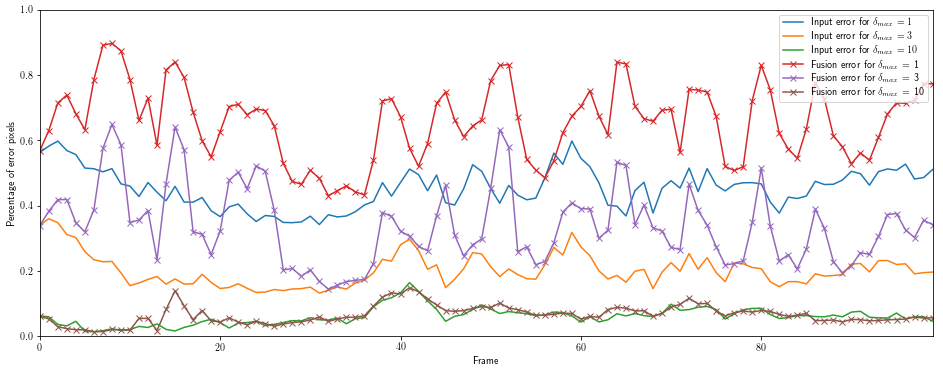

In [143]:
ax = frame_elas['input-error-percent-1'].plot(label='Input error for $\delta_{max} = 1$')
frame_elas['input-error-percent-3'].plot(ax=ax,label='Input error for $\delta_{max} = 3$')
# frame_elas['input-error-percent-5'].plot(ax=ax, label='Input error for $\delta_{max} = 5$')
frame_elas['input-error-percent-10'].plot(ax=ax, label='Input error for $\delta_{max} = 10$')
frame_elas['fusion-error-percent-1'].plot(ax=ax, marker='x', label="Fusion error for $\delta_{max}$ = 1")
frame_elas['fusion-error-percent-3'].plot(ax=ax, marker='x', label="Fusion error for $\delta_{max}$ = 3")
frame_elas['fusion-error-percent-10'].plot(ax=ax, marker='x', label="Fusion error for $\delta_{max}$ = 10")
ax.set_ylim([0,1])
ax.set_ylabel("Percentage of error pixels")
ax.set_xlabel("Frame")
ax.legend()

## Boxplots

We could use these plots to compare the error distributions for different scenes and different parameter configurations; for instance, we could show that errors tend to be smaller for dynamic scenes when dynamic objects are accounted for.

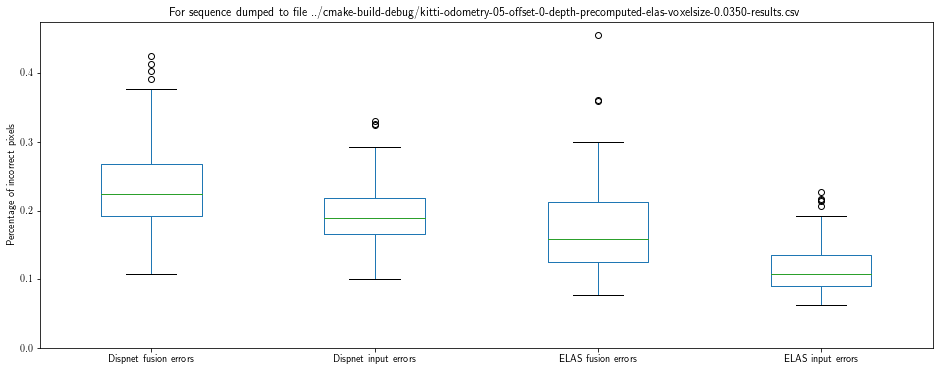

In [140]:
def boxplots(elas_frame, dn_frame, delta_max):
    bp_df = pd.DataFrame({
        'ELAS input errors': elas_frame['input-error-percent-{}'.format(delta_max)],
        'Dispnet input errors': dn_frame['input-error-percent-{}'.format(delta_max)],
        'ELAS fusion errors': elas_frame['fusion-error-percent-{}'.format(delta_max)],
        'Dispnet fusion errors': dn_frame['fusion-error-percent-{}'.format(delta_max)]
    })
    ax = bp_df.boxplot()
    ax.set_ylim([0, None])
    ax.set_ylabel("Percentage of incorrect pixels")
    ax.set_title("For sequence dumped to file {}".format(CSV_FILE_ELAS))
    ax.grid('off')
    
boxplots(frame_elas, frame_dn, delta_max=5)

Inspiration: the boxplots used for the point-to-plane distance based evaluation for LSD-SLAM:

![](img/lsd-slam-results.png)

Note how the libelas errors are actually smaller than their result fused over time. That's quite interesting...

Also note that we can't rely too much on their exact evaluation technique, which aligns MULTIPLE velodyne pointclouds for generating the ground truth, since it wouldn't work in evaluating the accuracy of reconstructing dynamic objects.

## Timeseries Plots 

These can highlight how errors change over time. For dynamic sequences but static reconstruction, these could show error spikes when other moving cars enter view. Then, we could show how (most of) those spikes are mitigated once we become aware of the dynamic objects and start reconstructing them separately.

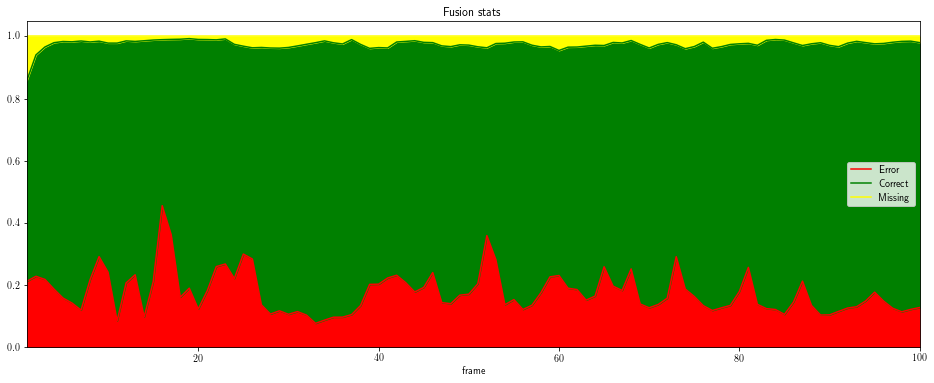

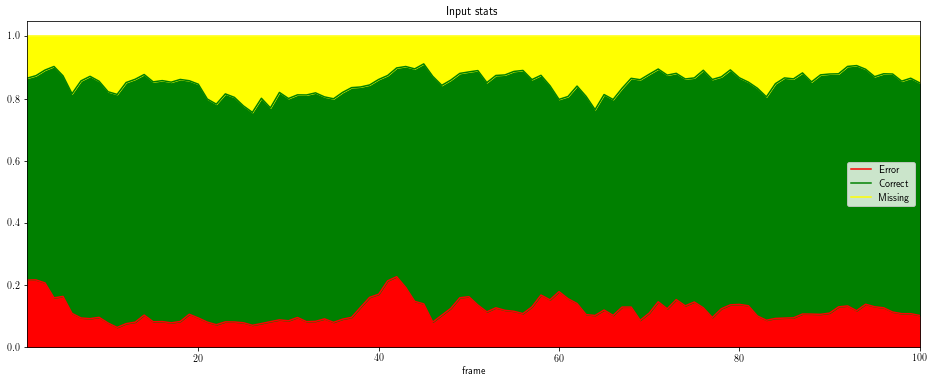

In [142]:
def timeplot(frame, delta=5):
    time_colors = ['red', 'green', 'yellow']
    time_names = ['Error','Correct','Missing']
    ax = frame.plot('frame', 
                  ['fusion-error-percent-{}'.format(delta), 
                   'fusion-correct-percent-{}'.format(delta),
                   'fusion-missing-percent-{}'.format(delta)],
                  'area',
                  stacked=True,
                  color=time_colors,
                  title="Fusion stats"
                 )
    ax.legend(time_names)

    ax2 = frame.plot('frame',
                        ['input-error-percent-{}'.format(delta),
                         'input-correct-percent-{}'.format(delta),
                         'input-missing-percent-{}'.format(delta)],
                  'area', stacked=True,
                  color=time_colors,
                  title="Input stats"
                 )
    ax2.legend(time_names)
    
timeplot(frame_elas, 5)

## Aggregate Accuracy Plots

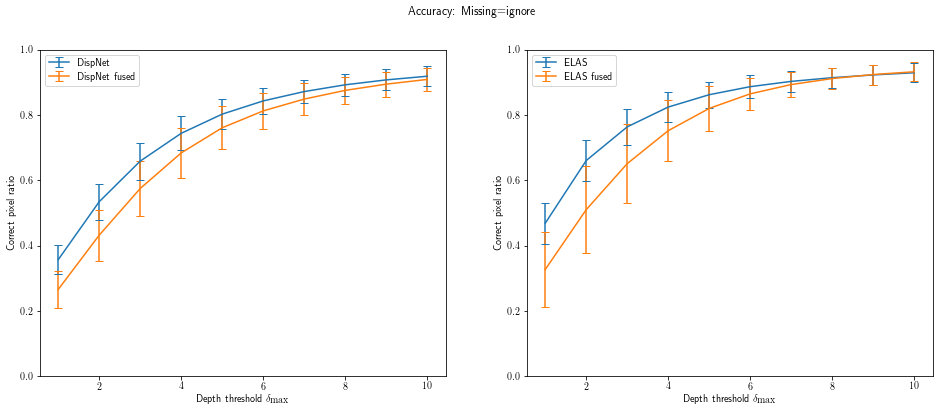

In [128]:
accs_input = []
accs_input_stds = []
accs_input_e = []
accs_input_stds_e = []
accs_fusion = []
accs_fusion_e = []
accs_fusion_stds = []
accs_fusion_stds_e = []

delta_maxes = range(1, 11)

def stats_for_delta(dframe, name, delta, include_missing):
    total = dframe['{}-total-{}'.format(name, delta)]
    error = dframe['{}-error-{}'.format(name, delta)]
    missing = dframe['{}-missing-{}'.format(name, delta)]
    correct = dframe['{}-correct-{}'.format(name, delta)]
    
    if include_missing:
        # Consider missing (uncomputed) values as errors
        accuracy = correct / total
    else:
        accuracy = correct / (total - missing)
        
    return accuracy.mean(), accuracy.std()

missing_are_errors = False
for i in delta_maxes:
    fus_acc_mean, fus_acc_std = stats_for_delta(frame_dn, 'fusion', i, missing_are_errors)
    fus_acc_mean_e, fus_acc_std_e = stats_for_delta(frame_elas, 'fusion', i, missing_are_errors)
    accs_fusion.append(fus_acc_mean)
    accs_fusion_stds.append(fus_acc_std)
    accs_fusion_e.append(fus_acc_mean_e)
    accs_fusion_stds_e.append(fus_acc_std_e)
    
    in_acc_mean, in_acc_std = stats_for_delta(frame_dn, 'input', i, missing_are_errors)
    in_acc_mean_e, in_acc_std_e = stats_for_delta(frame_elas, 'input', i, missing_are_errors)
    accs_input.append(in_acc_mean)
    accs_input_stds.append(in_acc_std)
    accs_input_e.append(in_acc_mean_e)
    accs_input_stds_e.append(in_acc_std_e)
    
plot_options = {
    'capsize': 4
}

# TODO look for best practices for mpl figures and use them
plt.subplot(121)
plt.errorbar(delta_maxes, accs_input, accs_input_stds, label='DispNet', **plot_options)
plt.errorbar(delta_maxes, accs_fusion, accs_fusion_stds, label='DispNet fused', **plot_options)
plt.xlabel(r"Depth threshold $\delta_{\textrm{max}}$")
plt.ylabel(r"Correct pixel ratio")
plt.ylim([0, 1])
plt.legend()


plt.subplot(122)
plt.errorbar(delta_maxes, accs_input_e, accs_input_stds_e, label='ELAS', **plot_options)
plt.errorbar(delta_maxes, accs_fusion_e, accs_fusion_stds_e, label='ELAS fused', **plot_options)
plt.xlabel(r"Depth threshold $\delta_{\textrm{max}}$")
plt.ylabel(r"Correct pixel ratio")
plt.ylim([0, 1])
plt.legend()

plt.suptitle("Accuracy: {}".format("Missing=error" if missing_are_errors else "Missing=ignore" ))


In [129]:
%ls img

itm-semantics-depth-plots.png  kitti-depth.png  lsd-slam-results.png


### Issues with the above plots

Right now, we get the unexpected result that the fused data is *less* accurate than the input depth maps. This is so far counterintuitive, since one would expect higher-quality depth maps once several frames are registered. However, this can also lead to an overall loss in precision, since the alignments are never perfect. Our results contradict those from Vineet et al. "Incremental Dense Semantic Stereo Fusion for Large-Scale Semantic Scene Reconstruction", who claim that, at least for static scenes, the fusion should, in fact, really help increase accuracy. Sengupta et al.'s evaluation uses the same principle but is terrible. They only show that their error decreases the higher they set the error tolerance...

"Reconstructing Street-Scenes in Real-Time from a Driving Car" are very thorough when comparing LIDAR to their sparse reconstructions. For them, single-frame ELAS *does* lead to lower error than maps fused over time.

Another interesting issue I've noticed is how the LIDAR-vs-fusion errors are particularly susceptible to bumps in the road. This is most clear in the KITTI odometry sequence 05, where we seem several spikes due to bumps in the road, causing the LIDAR gt to become temporarily misaligned with the map, but NOT with the camera input. Perhaps switching away from GT VO and using e.g. libviso2 VO may help alleviate this issue.

TODO(andrei): Update these notes once you try viso2 instead of GT.

Note that if we count missing pixels as errors, ELAS will always plateau below the fusion since its depth maps are incomplete in the bottom left and right, at least on e.g., KITTI sequence 06, but the fused map obviously no longer has this shortcoming after the first few frames. See:

![](img/kitti-depth.png)

Remaining issue: figure out WHY the error is higher for the fusion than for the input images (note that for Vineet et al. this *is* the case, at least in the dynamic sequences, unless they activate the semantics-based weighting):

![](img/itm-semantics-depth-plots.png)